In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score, f1_score,plot_confusion_matrix,plot_roc_curve



In [2]:
import numpy as np 
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

train = pd.read_csv("../input/preprocessedfraud/train_preprocessed.csv")
test = pd.read_csv("../input/preprocessedfraud/test_preprocessed.csv")

In [3]:
def submit(y_pred):
    sample = pd.read_csv('../input/submissiontemplate/submission.csv')
    sample.isFraud = y_pred
    sub_name = 'submission.csv'
    sample.to_csv(sub_name, index=False)

In [4]:
y = train[['isFraud']]

In [5]:
X = train.drop(['isFraud'], axis = 1)
del train

In [6]:
# over = RandomOverSampler(sampling_strategy=0.25)
# under = RandomUnderSampler(sampling_strategy=0.25)
# X_over, y_over = over.fit_resample(X, y)


In [7]:
# X_f, y_f = under.fit_resample(X_over, y_over)

## Hyperparamter Tuning

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [9]:
# y_train.values.ravel().shape

In [10]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
# estimators = [5, 10, 50, 100]
# max_depth = [1, 5, 10, 15, 20]
# param = {'n_estimators': estimators ,'max_depth':max_depth}
# model = RandomizedSearchCV(estimator=clf,  param_distributions=param, cv=3, n_iter=6, scoring='roc_auc')
# model.fit(X_train,y_train.values.ravel())

In [11]:
# model.best_params_

In [12]:
pred_valid = np.zeros(X.shape[0])
pred_test = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
cmx = []
main_features = []
roc_auc_scores = []

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle = True)
for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
    
    clf = RandomForestClassifier(max_depth=15,n_estimators=10)
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    clf.fit(X_train,y_train.values.ravel())
    
    pred_valid[valid_index] = clf.predict_proba(X_valid)[:, 1]
    pred_test += clf.predict_proba(test)[:, 1] / folds.n_splits
    roc_auc_scores.append(roc_auc_score(y_valid, pred_valid[valid_index]))
    print('Fold %2d AUC : %.6f' % (fold_n + 1, roc_auc_score(y_valid, pred_valid[valid_index]))) 
    
    # Confusion matrix
    cmx.append(confusion_matrix(y_valid, pred_valid[valid_index].round()))
    
    # Features importance
#     feature_imp = clf.feature_importances_(importance_type='gain')
#     main_features.append(feature_imp)
    


print('Full AUC score %.6f' % roc_auc_score(y, pred_valid))



Fold  1 AUC : 0.892664
Fold  2 AUC : 0.879230
Fold  3 AUC : 0.884256
Fold  4 AUC : 0.880539
Fold  5 AUC : 0.886807
Full AUC score 0.884420


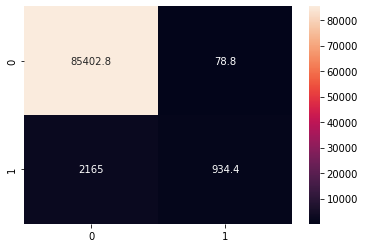

In [14]:
conf_matrix = np.average(cmx, axis= 0)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.show()


In [15]:
submit(pred_test)